## Prereq: python sim_cli.py --duration 120 --cores 24

In [1]:
import sim_analysis as plume_analysis
import sim_analysis
import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import config
print(config.dataset.keys())

dict_keys(['noisy1', 'noisy3x3', 'test', 'noisy3x2', 'switch45', 'noisy4', 'noisy3', 'constant25fps', 'constant', 'noisy3x1', 'constantx2', 'constantx3', 'constantx4', 'noisy2'])


In [2]:
# Simulator filename defaults
# fname_puff, fname_wind = 'puff_data_df.pickle', 'wind_data.pickle'
dataset = [
            'constant',
            'noisy1',
            'noisy2',
            'noisy3',
            'noisy4',
            'switch45',
    
            'constantx2', #6
            'noisy3x2', #7

            'constantx3', #8
            'noisy3x3', #9
           ][7]
print(dataset)
data_puffs, data_wind = plume_analysis.load_plume(dataset)

noisy3x2
noisy3x2


/home/satsingh/plume/plume2/sim_analysis.py:226: RuntimeWarning: overflow encountered in true_divide
  c = 1/(4/3.*np.pi*rad**3)


# Optimize memory

In [3]:
# import sys
# sys.getsizeof(data_puffs)/(1024**2), sys.getsizeof(data_wind)/(1024**2) # MBs

In [4]:
# data_puffs.memory_usage()
# data_puffs.info()

In [5]:
# # data_puffs['x'].memory_usage(), \
# #   data_puffs['x'].astype('float16').memory_usage(), \
# #   data_puffs['x'].astype('float32').memory_usage(), \
# #   data_puffs['x'].astype('float64').memory_usage(), \

# for df in [data_puffs, data_wind]:
#     for col in df.select_dtypes(include='float').columns:
#         df[col] = df[col].astype('float16')

# sys.getsizeof(data_puffs)/(1024**2), sys.getsizeof(data_wind)/(1024**2) # MBs

In [6]:
# data_wind.memory_usage()
# data_wind.info()

## Optimize speed

In [7]:
data_wind
# TODO: understand this difference
data_wind['time'].shape, data_wind['time'].unique().shape
# t_vals

((12100,), (12100,))

In [8]:
data_wind.iloc[100,:][['wind_x','wind_y']].tolist()#['wind_x', 'wind_y'].tolist()


[0.190185546875, 0.06182861328125]

In [9]:
# # Statements in plume_env
# import numexpr as ne

# def get_concentration_at_point_in_time_pandas(data, t_val, x_val, y_val):
#     # find the indices for all puffs that intersect the given x,y,time point
    
#     qx = str(x_val) + ' > x_minus_radius and ' + str(x_val) + ' < x_plus_radius'
#     qy = str(y_val) + ' > y_minus_radius and ' + str(y_val) + ' < y_plus_radius'
#     q = qx + ' and ' + qy
#     d = data[data["time"]==t_val].query(q)
#     return d.concentration.sum()

In [10]:
t_val = 90.0
# %timeit get_concentration_at_point_in_time_pandas( \
#     data_puffs, \
#     t_val, \
#     4 + np.random.uniform(-1, 1), \
#     np.random.uniform(-0.5, 0.5))

In [11]:
# %timeit data_wind.query("time == {}".format(t_val)).index[0]

In [12]:
# df_idx = data_wind.query("time == {}".format(t_val)).index[0]

# %timeit data_wind.loc[df_idx,['wind_x', 'wind_y']].tolist()

In [13]:
# %timeit data_wind.query("time == @t_val").iloc[0,:2].tolist() # Same


## Start data analysis

In [14]:
flip_multiplier = -1.0 if np.random.uniform() < 0.5 else 1.0 
data_puffs['y'] *= flip_multiplier
data_wind['wind_y'] *= flip_multiplier
print(flip_multiplier)

-1.0


In [15]:
data_puffs.head()

,puff_number,time,x,y,radius,concentration,x_minus_radius,x_plus_radius,y_minus_radius,y_plus_radius
0,0,0.03,0.000000,-0.000000,0.010002,0.0,-0.010002,0.010002,-0.010002,0.010002
1,0,0.04,0.000369,-0.006447,0.010101,0.0,-0.009735,0.010468,-0.003654,0.016541
2,0,0.05,0.000737,-0.012146,0.010201,0.0,-0.009460,0.010941,0.001945,0.022339
3,0,0.06,0.001106,-0.012161,0.010300,0.0,-0.009193,0.011406,0.001862,0.022461
4,0,0.07,0.001474,-0.016022,0.010399,0.0,-0.008926,0.011871,0.005623,0.026428


In [16]:
# data_puffs.groupby('puff_number').count()

In [17]:
data_puffs['puff_number'].unique().shape

def sparsify_puffs(data_puffs, sparsity=1.00):
    sparsity = np.clip(sparsity, a_min=0.01, a_max=1.00)
    if sparsity > 0.99:
        return data_puffs
    else:
        n_rows = data_puffs.shape[0]
        n_drop = int(n_rows * (1.00-sparsity))
        drop_idxs = [1]*n_drop + [0]*(n_rows - n_drop)
        np.random.shuffle(drop_idxs) # In place
        drop_idxs = np.argwhere(drop_idxs)[:,0] # Get idxs of all 1s
        return data_puffs.query("puff_number not in @drop_idxs")
    
data_puffs_sparse = sparsify_puffs(data_puffs, sparsity=0.999) # Reduce to test out f()

In [18]:
data_puffs['puff_number'].unique().shape, data_puffs_sparse['puff_number'].unique().shape

((2393,), (2393,))

In [19]:
data_wind.head()

,wind_x,wind_y,time
0,0.036865,-0.196533,0.00
1,0.036865,-0.196533,0.01
2,0.036865,-0.196533,0.02
3,0.036865,-0.196533,0.03
4,0.036865,-0.196533,0.04


/home/satsingh/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/satsingh/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/satsingh/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home/satsingh/anaconda3/lib/python

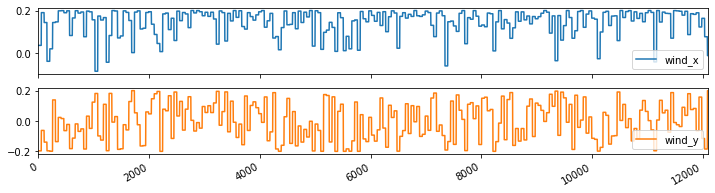

In [20]:
data_wind.iloc[:,:2].plot(subplots=True, figsize=(12,3));

In [21]:
data_wind.shape

(12100, 3)

In [22]:
# Size of puff(s) over time
# (data_puffs['x_plus_radius'] - data_puffs['x_minus_radius']).plot(figsize=(10,2));

In [23]:
# Size of puff(s) over time
# (data_puffs['y_plus_radius'] - data_puffs['y_minus_radius']).plot(figsize=(10,2));

In [24]:
t_val = data_wind['time'].iloc[-1]
t_val
# t_val = 70.0

120.99000000000001

0.199951    182
0.201782     48
0.205322     46
0.203857     45
0.210571     38
           ... 
0.442383      1
0.497559      1
0.564453      1
0.543945      1
0.360596      1
Length: 740, dtype: int64

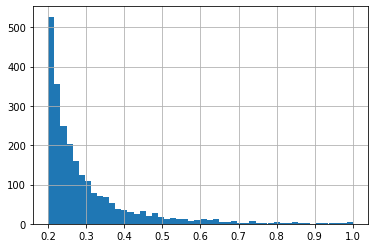

In [25]:
# Look at concentration distribution
data_at_t = data_puffs[data_puffs.time==t_val]
alphas = data_at_t.concentration.values

alphas /= np.max(alphas) # 0...1
alphas = np.power(alphas, 1/8)
alphas = np.clip(alphas, 0.2, 1.0)

pd.Series(alphas).hist(bins=50)
pd.Series(alphas).value_counts()




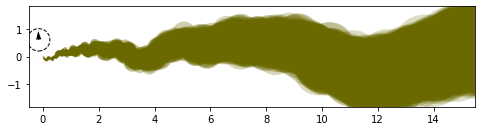

In [26]:
# t_val = min(60, t_val -1)
fname = ''
plotsize=(8,8) # this needs to be bigger than what comes out!
fig, ax = plume_analysis.plot_puffs_and_wind_vectors(data_puffs, data_wind, t_val, 
                                           fname=fname, plotsize=plotsize)

ax.set_xlim(-0.5, 15.5)
# ax.set_xlim(-0.5, 6.5)
ax.set_ylim(-1.8, +1.8)

# ax.set_xlim(-0.2, 2.5)
# ax.set_ylim(-0.5, 0.5)
if 'switch' in dataset:
    ax.set_xlim(-1, +10) # if switching
    ax.set_ylim(-5, +5) # if switching


# ax.set_ylim(-5, +5) # if switching
fig.savefig(f't{t_val:3.3f}.png')

In [27]:
# import mpl_scatter_density

# data_puffs_at_t = data_puffs.query('time == @t_val')

# xmin = -2 #data.x.min()
# xmax = 12 #data.x.max()
# ymin = -5 #data.y.min()
# ymax = +5 #data.y.max()

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

# s = ((ax.get_window_extent().width  / (xmax-xmin+1.) * 72./fig.dpi) ** 2)
# s=s*(data_puffs_at_t.radius)**2

# ax.scatter_density(data_puffs_at_t['x'], data_puffs_at_t['y'], s=s)
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)


# def plot_puffs(data, t_val, ax=None, show=True):
#     if ax is None:
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
#     else:
#         fig = ax.figure
        
#     xmin = -2 #data.x.min()
#     xmax = 12 #data.x.max()
#     ymin = -5 #data.y.min()
#     ymax = +5 #data.y.max()

#     data_at_t = data[data.time==t_val]

#     c = data_at_t.concentration
#     # print(c, t_val)

#     alphas = (np.log(c+1e-5)+np.abs(np.log(1e-5))).values
#     alphas /= np.max(alphas)
#     alphas[np.where(alphas<0)] = 0
#     alphas[np.where(alphas>1)] = 1    
#     min_alpha = 0.3 # ALIFE
#     alphas[np.where(alphas<min_alpha)] = min_alpha # ALIFE

#     rgba_colors = np.zeros((data_at_t.time.shape[0],4))
#     # rgba_colors[:,0] = 1.0 # Red
#     # rgba_colors[:,2] = 1.0 # Blue
#     # https://www.rapidtables.com/web/color/gray-color.html
#     # rgba_colors[:,0:2] = matplotlib.colors.to_rgba('red')[:2] 
#     rgba_colors[:,0:2] = matplotlib.colors.to_rgba('gray')[:2] 

#     # the fourth column needs to be your alphas
#     rgba_colors[:, 3] = alphas

#     # set limits
#     ax.set_xlim(xmin, xmax)
#     ax.set_ylim(ymin, ymax)
#     ax.set_aspect('equal')

#     fig.canvas.draw()
#     s = ((ax.get_window_extent().width  / (xmax-xmin+1.) * 72./fig.dpi) ** 2)

#     ax.scatter(data_at_t.x, data_at_t.y, s=s*(data_at_t.radius)**2, facecolor=rgba_colors, edgecolor='none')

#     if show:
#         plt.show()


## Data-driven initial location

In [28]:
Z = data_puffs[data_puffs.time==t_val].loc[:,['x','y']]
Z = Z.sample(n=1000, replace=False) if Z.shape[0] > 1000 else Z
X_pcts = Z['x'].quantile([0.65, 0.75]).to_numpy()
X_mean, X_var = X_pcts[1], X_pcts[1] - X_pcts[0]
print(X_mean, X_var)

Y_pcts = Z.query("(x >= @X_mean - @X_var) and (x <= @X_mean + @X_var)")['y'].quantile([0.05,0.5]).to_numpy()
Y_pcts
Y_mean, Y_var = Y_pcts[1], Y_pcts[1] - Y_pcts[0]
print(Y_mean, Y_var)

13.291015625 1.6492187499999993
-0.307861328125 0.46816406249999987


## Bbox calculate (and store?)

In [29]:
# https://stackoverflow.com/questions/16750618/whats-an-efficient-way-to-find-if-a-point-lies-in-the-convex-hull-of-a-point-cl
import numpy as np
from scipy.optimize import linprog

# Method 1: LP
def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success

n_points = 10000
n_dim = 10
Z = np.random.rand(n_points,n_dim)
x = np.random.rand(n_dim)
print(in_hull(Z, x))
# %timeit in_hull(Z, x) # 153 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# inZ = lambda x: in_hull(Z, x)

False


/home/satsingh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [30]:
# Method 2: Delaunay
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

cloud  = np.random.rand(50,2)
testset = np.random.rand(1,2)
print(in_hull(testset,cloud))

inZ = lambda x: in_hull(x,Z)

[False]


In [31]:
# Method 3: [Approx] within certain distance of cloud 

from scipy.spatial.distance import cdist 
def in_hull(cloud, x, threshold=1.5):
    Y = cdist(cloud, np.expand_dims(x,axis=0), metric='euclidean')
    return min(Y) < threshold

inZ = lambda x: in_hull(Z, x)

In [32]:
Z = data_puffs[data_puffs.time==t_val].loc[:,['x','y']].to_numpy()
Z = Z[np.random.choice(Z.shape[0], 1000, replace=False)] if Z.shape[0] > 1000 else Z

xmin = -0.1
xmax = 7
ymin = -5
ymax = +5
x = np.linspace(xmin, xmax, 10)
y = np.linspace(ymin, ymax, 10)
# xgrid, ygrid = np.meshgrid(x, y)
# xgrid.shape, ygrid.shape
grid = np.meshgrid(x, y)
grid = np.array(grid)
grid.shape

(2, 10, 10)

In [33]:
# np.apply_along_axis(np.sum, 0, grid).shape

In [34]:
# inZgrid = np.apply_along_axis(inZ, 0, grid) # 8.72s for 10x10 for LP
# inZgrid = np.apply_along_axis(inZ, 0, grid) # 8.4s for 10x10 for Delaunay
inZgrid = np.apply_along_axis(inZ, 0, grid)[0,:,:] # 8.4s for 10x10 for Delaunay
inZgrid.shape

(10, 10)

In [35]:
# %time np.apply_along_axis(inZ, 0, grid) 

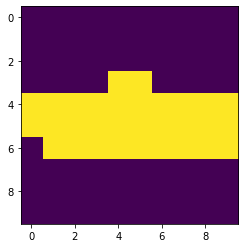

In [36]:
plt.imshow(inZgrid) # Holy cow it works!

## Animation

In [37]:
# Animation example -- works well!
# # https://stackoverflow.com/questions/15525431/how-to-fix-the-python-multiprocessing-matplotlib-savefig-issue
# import numpy as np
# from multiprocessing import Pool

# def graphing_function(i):
#     import matplotlib.pyplot as plt # within each process!
#     print(i)
#     plt.figure()
#     plt.scatter(*np.random.randn(100,2).T)
#     plt.savefig(f'tmp{i:04d}.png')
#     plt.close()
#     return

# pool = Pool(4)
# pool.map(graphing_function, [i for i in range(8)]) 

In [38]:
# Animation -- works well!

# from multiprocessing import Pool

# def graphing_function(t_val):
#     plotsize=(8,8) # this needs to be bigger than what comes out!
#     fig, ax = plume_analysis.plot_puffs_and_wind_vectors(data_puffs, data_wind, t_val, 
#                                                fname='', plotsize=plotsize)
#     ax.set_xlim(-0.5, 12.5)
#     ax.set_ylim(-1.5, +1.5)
#     fname = 'tmp/t{:012.8f}.png'.format(t_val)
#     fig.savefig(fname)
#     plt.close()
#     return fname

# pool = Pool(20)
# t_vals_anim = data_wind.query("time >= 60.0 and time <= 63.0")['time'] # TODO float32!
# fnames = pool.map(graphing_function, t_vals_anim) 

# from natsort import natsorted
# fnames = natsorted(fnames,reverse=False)
# len(fnames)

# # print( "ffmpeg -n -i '"'animation_%04d.jpg'"' animation.m4v")
# from moviepy.editor import ImageClip, concatenate_videoclips
# clips = [ImageClip(f).set_duration(0.02) for f in fnames] # 
# concat_clip = concatenate_videoclips(clips, method="compose")
# concat_clip.write_videofile("test.mp4", fps=30)

# # https://stackoverflow.com/questions/10840533/most-pythonic-way-to-delete-a-file-which-may-not-exist
# import contextlib
# import os
# for f in fnames:
#     with contextlib.suppress(FileNotFoundError):
#         os.remove(f)

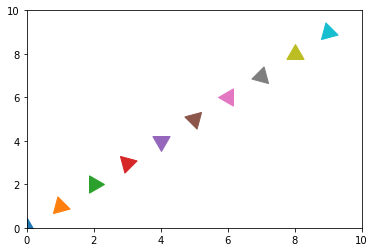

In [39]:
# import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/23345565/is-it-possible-to-control-matplotlib-marker-orientation
x = [r for r in range(10)]
for i in x:
#     plt.plot(i, i, marker=(4, 0, i*15-15), markersize=20, linestyle='None')
    plt.plot(i, i, marker=(3, 0, i*15), markersize=20, linestyle='None')



plt.xlim([0,10])
plt.ylim([0,10])

plt.show()

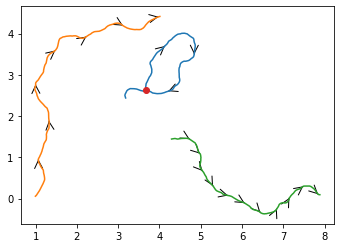

In [40]:
# Try directed arrows per
# https://stackoverflow.com/questions/47619545/how-to-plot-a-directed-line-in-matplotlib

import numpy as np ; np.random.seed(7)
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch 

class RL(object):
    def __init__(self, n, d, s=0.1):
        a = np.random.randn(n)*s
        a[0] = np.random.rand(1)*np.pi*2
        self.xy = np.random.rand(n,2)*5
        self.xy[1,:] = self.xy[0,:] + np.array([d*np.cos(a[0]),d*np.sin(a[0])])
        for i in range(2,n):
            (x,y), = np.diff(self.xy[i-2:i,:], axis=0)
            na = np.arctan2(y,x)+a[i]
            self.xy[i,:] = self.xy[i-1,:] + np.array([d*np.cos(na),d*np.sin(na)])
        self.x = self.xy[:,0]; self.y = self.xy[:,1]

l1 = RL(1000,0.005)
l2 = RL(1000,0.007)
l3 = RL(1000,0.005)

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(l1.x, l1.y)
ax.plot(l2.x, l2.y)
ax.plot(l3.x, l3.y)
ax.plot(l1.x[0], l1.y[0], marker="o")

def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]), 
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)

arrow(l1.x,l1.y,ax,3)
arrow(l2.x,l2.y,ax,6)
arrow(l3.x,l3.y,ax,10)

plt.show()